<a href="https://colab.research.google.com/github/cl3225/CHAZ/blob/main/Tutorial_chaz_pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tutorial for the Columbia HAZard (CHAZ) model** - Preprocessing

---
The Beta-version of CHAZ can be downloaded from GitHub https://github.com/cl3225/CHAZ. This tutorial converts the scripts into JupyterNB for better understanding of each of the components.

## Step 0: Set up enviroment

In [ ]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import xarray as xr
from datetime import datetime
import sys
import subprocess
import copy
from scipy import linalg
from scipy.interpolate import interp1d
from calendar import monthrange
from netCDF4 import Dataset
from scipy.interpolate import RectBivariateSpline

#import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Step 1: Set up pasic parameters

In [ ]:
# Basic parameters:

yearTC = 2017
path_data = 'doi:10.5281/zenodo.11631930' # public data available at https://zenodo.org/records/11628647

## Step 2: Preparing large-scale indicies & diagnostic variables
### Calculate the PI data. >> ds_pi
Here, we provide the code but don't run it, instead we directly load the PI data for the sake of time.
Python package [tcpyPI](https://github.com/dgilford/tcpyPI) is used.

In [ ]:
import pooch

'''
# Code to calculate ds_pi:
# load in pyPI modules
from tcpyPI import pi
from tcpyPI.utilities import *

def f_PI(ds, dim='p',CKCD=0.9):
    """ This function calculates PI over the given dataset using xarray """
    # calculate PI over the whole data set using the xarray universal function
    result = xr.apply_ufunc(
        pi,
        ds['sst'], ds['msl'], ds[dim], ds['t'], ds['q'],
        kwargs=dict(CKCD=CKCD, ascent_flag=0, diss_flag=1.0, V_reduc=0.8, ptop=30, miss_handle=0),
        input_core_dims=[[], [], [dim, ], [dim, ], [dim, ],],
        output_core_dims=[[], [], [], [], []],
        vectorize=True   # Vectorize the operation for better performance
    )

    # store the result in an xarray data structure
    vmax, pmin, ifl, t0, otl = result
    vmax = vmax.fillna(0)

    out_ds=xr.Dataset({
        'vmax': vmax,
        'pmin': pmin,
        'ifl': ifl,
        't0': t0,
        'otl': otl,
        })

    # add names and units to the structure
    out_ds.vmax.attrs['standard_name'],out_ds.vmax.attrs['units']='Maximum Potential Intensity','m/s'
    out_ds.pmin.attrs['standard_name'],out_ds.pmin.attrs['units']='Minimum Central Pressure','hPa'
    out_ds.ifl.attrs['standard_name']='pyPI Flag'
    out_ds.t0.attrs['standard_name'],out_ds.t0.attrs['units']='Outflow Temperature','K'
    out_ds.otl.attrs['standard_name'],out_ds.otl.attrs['units']='Outflow Temperature Level','hPa'

    # return the output from pi.py as an xarray data structure
    return out_ds

# Load data:

time_slice = slice(f'{yearTC}-01-01',f'{yearTC}-12-31')

fopen = pooch.retrieve(url=f"{path_data}/sea_surface_temperature_{yearTC}.nc",  known_hash=None)
ds_sst = xr.open_dataset(fopen).sel(time=time_slice).sst

fopen = pooch.retrieve(url=f"{path_data}/mean_sea_level_pressure_{yearTC}.nc",  known_hash=None)
ds_msl = xr.open_dataset(fopen).sel(time=time_slice).msl

fopen = pooch.retrieve(url=f"{path_data}/temperature_{yearTC}.nc",  known_hash=None)
ds_t = xr.open_dataset(fopen).sel(time=time_slice).t.sortby('level', ascending=False)

fopen = pooch.retrieve(url=f"{path_data}/specific_humidity_{yearTC}.nc",  known_hash=None)
ds_q = xr.open_dataset(fopen).sel(time=time_slice).q.sortby('level', ascending=False)

if sst.units== 'K':
    sst -= 273.15  # K >> degC
if msl.units=='Pa':
    msl /=100 # # Pa >> hPa
if t.units== 'K':
    t -= 273.15  # K >> degC
if q.units=='kg kg**-1':
    q *=1000 #kg/kg *1000 >> g/kg

# create new dataset that contains all the input variables
ds = xr.Dataset(
    data_vars=dict(
        sst = (['time','lat','lon'], ds_sst.data),
        msl = (['time','lat','lon'], ds_msl.data),
        t = (['time','p','lat','lon'], ds_t.data),
        q = (['time','p','lat','lon'], ds_q.data), ),
    coords=dict(
        p=("p", t.level.data),
        lat=("lat", sst.latitude.data),
        lon=("lon", sst.longitude.data),
        time=("time", sst.time.data),))

# Regrid to 2deg to speed up
regridder = xe.Regridder(ds, grid_2deg, 'bilinear')
ds_rg = regridder(ds)

# Calulate PI:
ds_PI = f_PI(ds_rg)
'''

fopen = pooch.retrieve(url=f"{path_data}/PI_{yearTC}.nc",  known_hash='4fa7388fbd896c5ceb1b1a8dd4a88dd5352973e07471a5cb7d96643cd2263e87')
ds_pi = xr.open_dataset(fopen)

### Calculate TCGI >> ds_tcgi_crh & ds_tcgi_sd
TCGI is a genesis index for estimating probability of TC formation rate in time and space. Here, we provide the TCGI data. The TCGI code will be released in soon. Meanwhile, please contact Prof. Suzana Camargo at Columbia Univeristy if you need it.

Alternatively, you can use observed TC foramtion probability or other forms of TC genesis indices

In [ ]:
'''
## Source code for tcgi calculation:

'''

fopen = pooch.retrieve( url=f"{path_data}/TCGI_CRH_PI_{yearTC}.nc",
                        known_hash='a8d3e6dfbbd4bd4ea149876318132bfc04f6c1e6bfa6081570bd38ff3137004e' )
ds_tcgi_crh = xr.open_dataset(fopen)

fopen = pooch.retrieve( url=f"{path_data}/TCGI_SD_PI_{yearTC}.nc",
                        known_hash='d7e7e6bd46117a45057da7321402cc3335bb92d946e75eed1446185aef985fad' )
ds_tcgi_sd = xr.open_dataset(fopen)

### Calculate the variance of the syntheric 250 and 850 hpa wind flow for TC tracks generation >> ds_cov; A_matrix

In [ ]:
## Functions for calculating cov and A:

def my_cov(x, y, naxis):
    """
    Calculate the covariance matrix between two array (x,y).
    """
    n = x.shape[naxis]
    cov_bias = np.mean(x * y, axis=naxis) - (np.mean(x, axis=naxis) * np.mean(y, axis=naxis))
    cov_bias = cov_bias * n / (n - 1)
    return cov_bias

def fillinNaN(var, neighbors):
    """
    This function fills in 'NaN' values (masked areas) in a variable var using interpolation from its neighboring values.
    """
    for ii in range(var.shape[0]):
        a = var[ii, :, :]
        while np.any(a.mask):
            a_copy = a.copy()
            for hor_shift, vert_shift in neighbors:
                if not np.any(a.mask):
                    break
                a_shifted = np.roll(np.roll(a_copy, shift=hor_shift, axis=1), shift=vert_shift, axis=0)
                idx = a.mask & ~a_shifted.mask
                a[idx] = a_shifted[idx]
        var[ii, :, :] = a
    return var

def date_interpolation(dateInput,fileInput):
        """
        This function interpolates data fields based on the input date, handling different scenarios based on the day and month of dateInput
        """
        if dateInput.day >= 15:
                if dateInput.month < 12:
                        date0 = datetime(dateInput.year,dateInput.month,15,0,0)
                        date1 = datetime(dateInput.year,dateInput.month+1,15,0,0)
                        dfdays = (dateInput-date0).days
                        xp = [0, (date1-date0).days]
                        ratio = np.interp(dfdays,xp,[0,1])
                        fileOutput = fileInput[dateInput.month-1,:,:]*(1-ratio)+fileInput[dateInput.month,:,:]*(ratio)
                else:
                        fileOutput= fileInput[dateInput.month-1,:,:]
        else:
                if dateInput.month == 1:
                        fileOutput= fileInput[dateInput.month-1,:,:]
                else:
                        date0 = datetime(dateInput.year,dateInput.month-1,15,0,0)
                        date1 = datetime(dateInput.year,dateInput.month,15,0,0)
                        dfdays = (dateInput-date0).days
                        xp = [0, (date1-date0).days]
                        ratio = np.interp(dfdays,xp,[0,1])
                        fileOutput = fileInput[dateInput.month-2,:,:]*(1-ratio)+fileInput[dateInput.month-1,:,:]*ratio
        return fileOutput

# code to save the A matrix; per month:
def createNetCDF_A(A1,iy,im,xllon,xllat,path):
        """
        crerate NetCDF file for the syn wind, it will be 124MB each
        """
        nc = Dataset(f'A_{iy:04d}{im:02d}.nc','w',format='NETCDF3_CLASSIC')
        nc.createDimension('latitude',xllat.shape[0])
        nc.createDimension('longitude',xllon.shape[0])
        nc.createDimension('days',A1.shape[3])
        nc.createDimension('Adim',A1.shape[0])
        lats = nc.createVariable('latitude',np.dtype('float32').char,('latitude',))
        lons = nc.createVariable('longitude',np.dtype('float32').char,('longitude',))
        days = nc.createVariable('days',np.dtype('int32').char,('days',))
        Adim = nc.createVariable('Adim',np.dtype('int32').char,('Adim',))
        lats.units = 'degrees_north'
        lons.units = 'degrees_east'
        days.units = 'days_in_month'
        Adim.units = 'dimensions_in_A'
        lats[:] = xllat
        lons[:] = xllon
        days[:] = list(range(0,A1.shape[3],1))
        Adim[:] = list(range(0,A1.shape[0],1))
        AA = nc.createVariable('A',np.dtype('float32').char,('Adim','days','latitude','longitude'))
        AA.units = ''
        AA[:] = np.rollaxis(A1,3,1)
        nc.close()
        return()

In [ ]:
iy = copy.copy(yearTC)
## Load montly and daily u, v wind field   #  Here use ERA5 as the example, can be modify to model simulation data:
print(f'Calculating covarience between monthly and daily winds for SEASON {iy} .....\n')

fopen  = pooch.retrieve( url=f"{path_data}/u_v_850_250_2deg_2017_monthly.nc", known_hash=None )
ds_uvm = xr.open_dataset(fopen)

fopen  = pooch.retrieve( url=f"{path_data}/u_v_850_250_2deg_2017_daily.nc", known_hash=None )
ds_uvd = xr.open_dataset(fopen)


## [1] Interpolate monthly data to daily data
d = np.arange(0, ds_uvd.time.shape[0])

#     1) Def interpolation func.
def interpolate_monthly_to_daily(monthly_data, d):
  ndays_year = 0
  m = []
  for im in range(1,13):
    m.append([monthrange(iy,im)[1]/2+ndays_year])
    ndays_year = ndays_year+monthrange(iy,im)[1]
  m = np.squeeze(np.int_(m)-1) #print(m)
  f = interp1d(m, monthly_data, bounds_error=False,fill_value="extrapolate",axis=0)
  return f(d)

#      2) Interpolate montly data to daily data:
ua250md = interpolate_monthly_to_daily(ds_uvm.u250.values, d)
va250md = interpolate_monthly_to_daily(ds_uvm.v250.values, d)
ua850md = interpolate_monthly_to_daily(ds_uvm.u850.values, d)
va850md = interpolate_monthly_to_daily(ds_uvm.v850.values, d)

## [2] Now we calculate the monthly cov.
#     1) Initialize covariance matrix; #varx-vary converience; total 10
var_pairs = ['u250pu250p', 'u250pv250p', 'u250pu850p', 'u250pv850p',
              'v250pv250p', 'v250pu850p', 'v250pv850p',
              'u850pu850p', 'u850pv850p', 'v850pv850p']

covMatrix = np.zeros([len(var_pairs), 12, va250md.shape[1], va250md.shape[2]])

#     2) Generate month indices for quick access
month_indices = {im: list(np.where(ds_uvd['time.month'].values == im)[0]) for im in range(1, 13)}

#     3) Loop through each month to calculate the COV
for im in range(1, 12+1):
    indices = month_indices[im]
    u250p = ds_uvd.u250.values[indices, :, :] - ua250md[indices, :, :]
    u850p = ds_uvd.u850.values[indices, :, :] - ua850md[indices, :, :]
    v250p = ds_uvd.v250.values[indices, :, :] - va250md[indices, :, :]
    v850p = ds_uvd.v850.values[indices, :, :] - va850md[indices, :, :]

    var_data = {  'u250p': u250p.reshape([u250p.shape[0], u250p.shape[1] * u250p.shape[2]]),
                  'v250p': v250p.reshape([u250p.shape[0], u250p.shape[1] * u250p.shape[2]]),
                  'u850p': u850p.reshape([u250p.shape[0], u250p.shape[1] * u250p.shape[2]]),
                  'v850p': v850p.reshape([u250p.shape[0], u250p.shape[1] * u250p.shape[2]]) }

    for ivar, var_pair in enumerate(var_pairs):
        varx_name = var_pair[:5]
        varx = var_data[varx_name]

        vary_name = var_pair[-5:]
        vary = var_data[vary_name]

        covMatrix[ivar, im-1,:,:] = my_cov(varx, vary, 0).reshape([u250p.shape[1], u250p.shape[2]])
        print(f'Get cov for {iy} , month {im}, between {varx_name} & {vary_name}')

## Save the COV data:
ds_cov = xr.Dataset({vname: (('month', 'lat', 'lon'), covMatrix[idx])
                for idx, vname in enumerate(var_pairs)},
                    coords={
                        'month': np.arange(1, 12 + 1),
                        'lat': ds_uvm.lat.values,
                        'lon': ds_uvm.lon.values
                        }
                )

ds_cov['lat'].attrs['units'] = 'degrees_north'
ds_cov['lon'].attrs['units'] = 'degrees_east'
ds_cov['month'].attrs['units'] = 'month_in_year'
for vname in var_pairs:
    ds_cov[vname].attrs['units'] = '(m/s)^2'

Calculating covarience between monthly and daily winds for SEASON 2017 .....



SHA256 hash of downloaded file: 26ad6ce62254f57d9e910dbab19460c02dcdf2fe2237ac477ee733a43260cdcf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: a708d20730d44a63cd71e407438905f201ebca777040a86158a83b3fca1cf1a8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Get cov for 2017 , month 1, between u250p & u250p
Get cov for 2017 , month 1, between u250p & v250p
Get cov for 2017 , month 1, between u250p & u850p
Get cov for 2017 , month 1, between u250p & v850p
Get cov for 2017 , month 1, between v250p & v250p
Get cov for 2017 , month 1, between v250p & u850p
Get cov for 2017 , month 1, between v250p & v850p
Get cov for 2017 , month 1, between u850p & u850p
Get cov for 2017 , month 1, between u850p & v850p
Get cov for 2017 , month 1, between v850p & v850p
Get cov for 2017 , month 2, between u250p & u250p
Get cov for 2017 , month 2, between u250p & v250p
Get cov for 2017 , month 2, between u250p & u850p
Get cov for 2017 , month 2, between u250p & v850p
Get cov for 2017 , month 2, between v250p & v250p
Get cov for 2017 , month 2, between v250p & u850p
Get cov for 2017 , month 2, between v250p & v850p
Get cov for 2017 , month 2, between u850p & u850p
Get cov for 2017 , month 2, between u850p & v850p
Get cov for 2017 , month 2, between v850p & v850p


In [ ]:
%%time
# if ds_cov is not calculated, load from the path_data:
# fopen = pooch.retrieve(url=f"{path_data}/Cov_2017_2deg.nc", known_hash=None)
# ds_cov = xr.open_dataset(fopen)

nlat = ds_cov.lat.shape[0]
nlon = ds_cov.lon.shape[0]
ncov = len(ds_cov.data_vars)
xllon = ds_cov.variables['lon'].values
xllat = ds_cov.variables['lat'].values

# Extract the covariance data
var = ['u250p', 'v250p', 'u850p', 'v850p']
cov = {}
for iv in range(len(var)):
    for iiv in range(iv, len(var)):
        vname = var[iv] + var[iiv]
        cov[vname] = ds_cov[vname].values
        cov[vname][:, 0, :] = cov[vname][:, 1, :]
        cov[vname][:, -1, :] = cov[vname][:, -2, :]

for im in range(1, 12 + 1):
    nday = monthrange(iy, im)[1]
    dates = [datetime(iy, im, iday, 0, 0) for iday in range(1, nday + 1)]

    # Perform date interpolation for all dates at once
    cov2d = {vname: np.dstack([date_interpolation(date, cov[vname]) for date in dates]) for vname in cov}

    a_shape = cov2d[list(cov2d.keys())[0]].shape
    covm2d = np.stack([cov2d[vname] for vname in cov2d], axis=0)

    covv = np.zeros((4, 4) + a_shape)
    covv[0, :, :, :, :] = covm2d[:4, :, :, :]
    covv[1, 1:, :, :, :] = covm2d[4:7, :, :, :]
    covv[2, 2:, :, :, :] = covm2d[7:9, :, :, :]
    covv[3, 3, :, :, :] = covm2d[9, :, :, :]

    # Vectorize the Cholesky decomposition
    A = np.zeros_like(covv)
    mask = np.isnan(covv).any(axis=(0, 1))
    covv_clean = covv[:, :, ~mask]
    A_clean = np.linalg.cholesky(covv_clean.T).T
    A[:, :, ~mask] = A_clean

    A2 = np.zeros((10,) + a_shape)
    A2[0, :, :, :] = A[0, 0, :, :, :]
    A2[1, :, :, :] = A[1, 0, :, :, :]
    A2[2, :, :, :] = A[1, 1, :, :, :]
    A2[3, :, :, :] = A[2, 0, :, :, :]
    A2[4, :, :, :] = A[2, 1, :, :, :]
    A2[5, :, :, :] = A[2, 2, :, :, :]
    A2[6, :, :, :] = A[3, 0, :, :, :]
    A2[7, :, :, :] = A[3, 1, :, :, :]
    A2[8, :, :, :] = A[3, 2, :, :, :]
    A2[9, :, :, :] = A[3, 3, :, :, :]

    print(f'calculate A for {yearTC}-{im}, A.shape = ', A2.shape)

    createNetCDF_A(A2, iy, im, xllon, xllat, './')

calculate A for 2017-1, A.shape =  (10, 90, 180, 31)
calculate A for 2017-2, A.shape =  (10, 90, 180, 28)
calculate A for 2017-3, A.shape =  (10, 90, 180, 31)
calculate A for 2017-4, A.shape =  (10, 90, 180, 30)
calculate A for 2017-5, A.shape =  (10, 90, 180, 31)
calculate A for 2017-6, A.shape =  (10, 90, 180, 30)
calculate A for 2017-7, A.shape =  (10, 90, 180, 31)
calculate A for 2017-8, A.shape =  (10, 90, 180, 31)
calculate A for 2017-9, A.shape =  (10, 90, 180, 30)
calculate A for 2017-10, A.shape =  (10, 90, 180, 31)
calculate A for 2017-11, A.shape =  (10, 90, 180, 30)
calculate A for 2017-12, A.shape =  (10, 90, 180, 31)
CPU times: user 3.85 s, sys: 1.87 s, total: 5.72 s
Wall time: 5.63 s


## Step 3: Get the predictors for TC intensity model >> ds_regrid

In [ ]:
def interp2_fx(lon, lat, X):
    if lat[1] - lat[0] < 0:
        # Reverse grid since x and y must be strictly increasing.
        r_lat = np.flip(lat, 0)
        r_X = np.flip(X, 0).T
    else:
        r_lat = lat
        r_X = X.T

    # Interpolate SST grid to the model grid.
    f_X = RectBivariateSpline(lon, r_lat, r_X, kx=1, ky=1)
    return(f_X)

"""
2-D interpolation. Interpolates a field X (dimensions [lat, lon]),
to a grid defined by [lat_grid, lon_grid].
"""
def interp_2d_grid(lon, lat, X, lon_grid, lat_grid):
    f_X = interp2_fx(lon, lat, X)

    LON, LAT = np.meshgrid(lon_grid, lat_grid)
    X_grid = f_X.ev(LON, LAT)
    return(X_grid)


In [ ]:
# Calculation of predictors:
time_slice = slice(f'{yearTC}-01-01',f'{yearTC}-12-31')
fopen = pooch.retrieve( url=f"{path_data}/u_component_of_wind_{iy}.nc", known_hash=None )
ds_u= xr.open_dataset(fopen)

fopen = pooch.retrieve( url=f"{path_data}/v_component_of_wind_{iy}.nc", known_hash=None )
ds_v= xr.open_dataset(fopen)

fopen = pooch.retrieve( url=f"{path_data}/relative_humidity_{iy}.nc", known_hash=None )
ds_r= xr.open_dataset(fopen)


u850 = ds_u.sel(level=850, method='nearest').u
u250 = ds_u.sel(level=250, method='nearest').u
v850 = ds_v.sel(level=850, method='nearest').v
v250 = ds_v.sel(level=250, method='nearest').v
hur  = ds_r.sel(level=[500, 700, 850], method='nearest').mean('level').r

# # Create the dataset
ds = xr.Dataset()
ds['u850'] = (('time','lat','lon'), u850.values)
ds['u250']  = (('time','lat','lon'), u250.values)
ds['v850']  = (('time','lat','lon'), v850.values)
ds['v250']  = (('time','lat','lon'), v250.values)
ds['hur']  = (('time','lat','lon'),  hur.values)

# Assign coordinates
ds.coords['lat'] = (('lat'), ds_u.latitude.values)
ds.coords['lon'] = (('lon'), ds_u.longitude.values)
ds.coords['time'] = (('time'), ds_u.time.values)
ds.coords['month'] = (('month'), np.arange(1,13))

# Assign units and long_name to variables
ds['u250'].attrs['units'] = 'm/s'
ds['u250'].attrs['long_name'] = '250 hPa zonal wind'

ds['u850'].attrs['units'] = 'm/s'
ds['u850'].attrs['long_name'] = '850 hPa zonal wind'

ds['v250'].attrs['units'] = 'm/s'
ds['v250'].attrs['long_name'] = '250 hPa meridional wind'

ds['v850'].attrs['units'] = 'm/s'
ds['v850'].attrs['long_name'] = '850 hPa meridional wind'

ds['hur'].attrs['units'] = '%'
ds['hur'].attrs['long_name'] = 'Relative humidity averaged over 500, 700 and 850 hpa'

keys = list(ds.keys())
da_vars = []
for key in keys:
  out = ([interp_2d_grid(ds['lon'],ds['lat'],ds[key].sel(time=np.datetime64(str(yearTC)+"-%02d-01" % x)), ds_pi['lon'],ds_pi['lat']) for x in range(1, 13)])
  da_vars.append(xr.DataArray(data = np.concatenate([arr[np.newaxis, ...] for arr in out]), dims = ['time', 'lat', 'lon'], coords = {'time': ds['time'].data, 'lon': ds_pi['lon'].data, 'lat': ds_pi['lat'].data}).rename(key))
ds_regrid = xr.merge(da_vars)
ds_regrid['PI'] = (('time','lat','lon'),  ds_pi.vmax.values)
ds_regrid.to_netcdf(f"I_MLR_{yearTC}.nc")

SHA256 hash of downloaded file: c616d470458544c6501da4b7f1df40f96cfe06868000646b8641e7e8a8f083eb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: d8e1cbf0d035205b7099c8c669b5e5b034b9ef6ab9e33c0e2e7d25c78770f763
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 5389ec5639d48eac56b5f00d166d644c786d1578f1b06f666ac6dcade6ff9088
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


### Step 4: It is always good to check your data

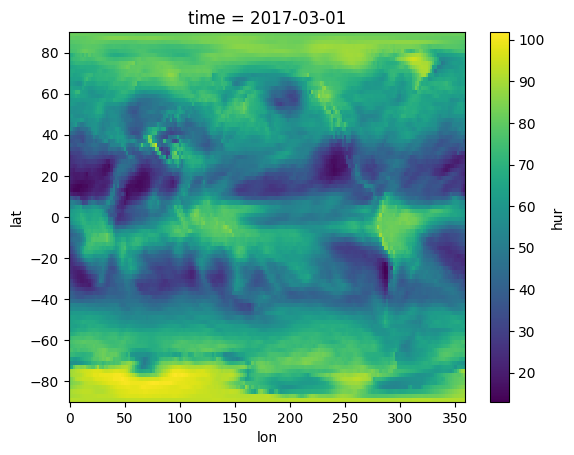

In [ ]:
ds_regrid['hur'][2].plot.pcolormesh()